In [136]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import spatial

from mutspec.utils.annot import mutations_summary, calculate_mutspec
from mutspec.utils import possible_sbs192, possible_sbs12

## Load mutations

In [2]:
path_to_mutations_simple = "../data/processed/nematoda/dif_approaches/simple/mutations.tsv"

mut_simple = pd.read_csv(path_to_mutations_simple, sep='\t')
mut_simple["MutBase"] = mut_simple["Mut"].str.slice(2, 5)
print(mut_simple.shape)
mut_simple.head()

(98584, 12)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,RefNode,AltNode,Gene,MutBase
0,T[T>G]T,0,6,3,ATT,ATG,I,M,Node4,Node5,ATP6,T>G
1,A[A>G]G,0,163,1,AGT,GGT,S,G,Node4,Node5,ATP6,A>G
2,A[G>A]T,0,208,1,GTT,ATT,V,I,Node4,Node5,ATP6,G>A
3,T[A>T]T,0,241,1,ATA,TTA,M,L,Node4,Node5,ATP6,A>T
4,T[A>T]A,0,274,1,AAT,TAT,N,Y,Node4,Node5,ATP6,A>T


In [23]:
path_to_mutations_proba = "../data/processed/nematoda/dif_approaches/iqtree/mutations.tsv"

mut_iqtree = pd.read_csv(path_to_mutations_proba, sep='\t')
mut_iqtree["MutBase"] = mut_iqtree["Mut"].str.slice(2, 5)
print(mut_iqtree.shape)
mut_iqtree.head()

(11336085, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,A[A>T]T,0,4,1,ATG,TTG,M,L,0.223653,0.025558,0.017733,Node4,Node5,ATP6,A>T
1,A[T>A]T,0,4,1,TTG,ATG,L,M,0.074923,0.016245,0.011271,Node4,Node5,ATP6,T>A
2,A[A>T]T,0,4,1,ATT,TTT,I,F,0.266994,0.025577,0.017746,Node4,Node5,ATP6,A>T
3,A[T>A]T,0,4,1,TTT,ATT,F,I,0.089443,0.016258,0.011280,Node4,Node5,ATP6,T>A
4,G[A>T]T,0,4,1,ATG,TTG,M,L,0.046939,0.001242,0.000862,Node4,Node5,ATP6,A>T


In [4]:
path_to_mutations_pastml = "../data/processed/nematoda/dif_approaches/pastml/mutations.tsv"

mut_pastml = pd.read_csv(path_to_mutations_pastml, sep='\t')
mut_pastml["MutBase"] = mut_pastml["Mut"].str.slice(2, 5)
print(mut_pastml.shape)
mut_pastml.head()

(3615949, 15)


,Mut,Label,PosInGene,PosInCodon,RefCodon,AltCodon,RefAa,AltAa,ProbaRef,ProbaMut,ProbaFull,RefNode,AltNode,Gene,MutBase
0,G[T>A]A,0,53,2,GTA,GAA,V,E,0.054248,0.001046,0.001046,Node4,Node5,ATP6,T>A
1,T[T>A]A,-1,53,2,TTA,TAA,L,*,0.072780,0.002390,0.002390,Node4,Node5,ATP6,T>A
2,T[T>G]A,0,53,2,TTA,TGA,L,W,0.072780,0.000913,0.000913,Node4,Node5,ATP6,T>G
3,T[T>A]G,-1,53,2,TTG,TAG,L,*,0.029787,0.000400,0.000400,Node4,Node5,ATP6,T>A
4,G[A>G]T,0,53,2,GAT,GGT,D,G,0.012598,0.000448,0.000448,Node4,Node5,ATP6,A>G


### Simple

In [5]:
mutations_summary(mut_simple, "Gene")

,non-syn,syn,syn4f,Stop loss,Stop gain
Gene,,,,,
ATP6,1932,1562,1668,3,2
COX1,2338,4939,6444,3,1
COX2,1593,2325,2283,1,0
COX3,2030,2563,2928,4,0
CYTB,3432,3632,3998,4,3
ND1,2763,2954,3036,6,2
ND2,3861,2723,1851,5,4
ND3,1290,1088,863,3,0
ND4,4451,4024,4173,7,2


### Proba iqtree with evol coef

In [6]:
msum_pr = mutations_summary(mut_iqtree, "Gene", "ProbaFull")
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,5679.8,2106.0,2146.4,142.9,139.9,12.7
COX1,4079.1,5838.1,7373.2,60.4,58.4,3.9
COX2,3736.8,2919.0,2615.1,71.7,69.6,5.8
COX3,3128.3,3129.0,3426.2,40.5,36.4,2.5
CYTB,4998.0,4388.7,4715.7,52.1,46.6,3.0
ND1,4631.3,3644.5,3700.0,62.2,58.0,3.4
ND2,8161.2,3710.9,2393.9,96.0,88.6,8.4
ND3,2160.8,1393.7,1080.7,29.4,27.0,2.4
ND4,6087.4,4894.2,5128.6,43.4,34.8,4.0


In [7]:
mut_iqtree.ProbaFull.max()

0.99935335

In [53]:
_mtypes_cnt = mut_iqtree.groupby("Label").ProbaFull.sum()
print("IQTREE: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

IQTREE: 0.01049% of all sbs are stop loss/gain sbs


Label
-3       59.390052
-2      767.656593
-1      710.282059
 0    57798.381784
 1    40648.099773
 2    40867.478737
Name: ProbaFull, dtype: float64

In [56]:
_mtypes_cnt = mut_iqtree[mut_iqtree.ProbaFull > 0.1].groupby("Label").ProbaFull.sum()
print("IQTREE filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

IQTREE filtered: 0.00065% of all sbs are stop loss/gain sbs


Label
-2       52.442373
-1       13.106994
 0    30594.799615
 1    34620.634077
 2    35052.900744
Name: ProbaFull, dtype: float64

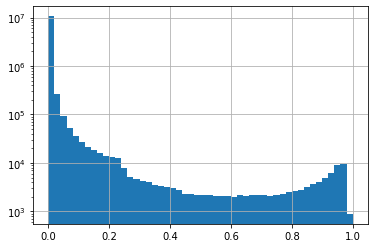

In [20]:
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.show()

### Proba pastml

In [26]:
msum_pr = mutations_summary(mut_pastml, "Gene", "ProbaFull")
msum_pr["syn"] += msum_pr["syn4f"]
msum_pr.round(1)

,non-syn,syn,syn4f,Stop loss,Stop gain,Stop to stop
Gene,,,,,,
ATP6,2113.6,6021.9,3314.8,16.3,5.9,0.3
COX1,2654.4,25965.5,15134.5,7.3,3.0,0.1
COX2,1795.3,10162.4,4985.8,13.7,4.6,0.8
COX3,2358.8,12416.7,6635.8,14.2,5.3,0.3
CYTB,4038.0,17189.6,9234.2,25.4,9.7,1.0
ND1,3468.2,13221.9,6864.5,14.7,4.8,0.3
ND2,4982.3,9076.2,3554.3,24.7,8.1,0.5
ND3,1649.6,3875.8,1666.3,7.8,3.4,0.1
ND4,5582.5,18137.7,9321.7,25.0,8.9,1.1


In [58]:
mut_pastml.groupby("Label").ProbaFull.sum()

_mtypes_cnt = mut_pastml.groupby("Label").ProbaFull.sum()
print("PASTML: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

PASTML: 0.00159% of all sbs are stop loss/gain sbs


Label
-3        7.029762
-2      214.446447
-1       80.521970
 0    39717.038516
 1    70103.517651
 2    74926.573334
Name: ProbaFull, dtype: float64

In [60]:
_mtypes_cnt = mut_pastml[mut_pastml.ProbaFull > 0.1].groupby("Label").ProbaFull.sum()
print("PASTML filtered: {:.5f}% of all sbs are stop loss/gain sbs".format(_mtypes_cnt[[-1, -2]].sum() / _mtypes_cnt.sum()))
_mtypes_cnt

PASTML filtered: 0.00044% of all sbs are stop loss/gain sbs


Label
-3        0.339834
-2       50.726127
-1        6.264602
 0    23784.483653
 1    55161.352605
 2    49921.650830
Name: ProbaFull, dtype: float64

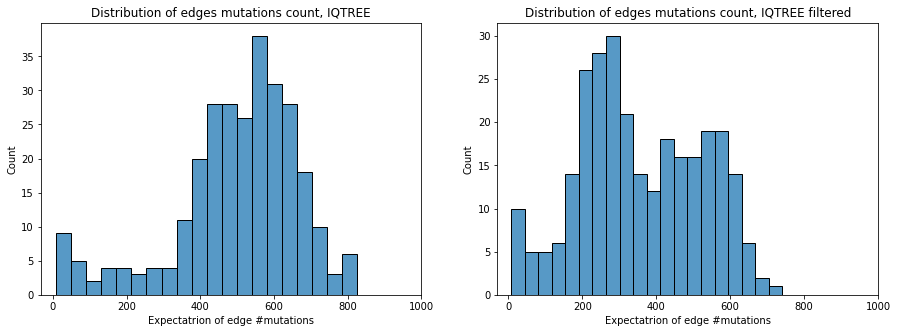

In [69]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(mut_iqtree.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.subplot(122)
sns.histplot(mut_iqtree[mut_iqtree.ProbaFull > 0.1].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, IQTREE filtered")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.show()

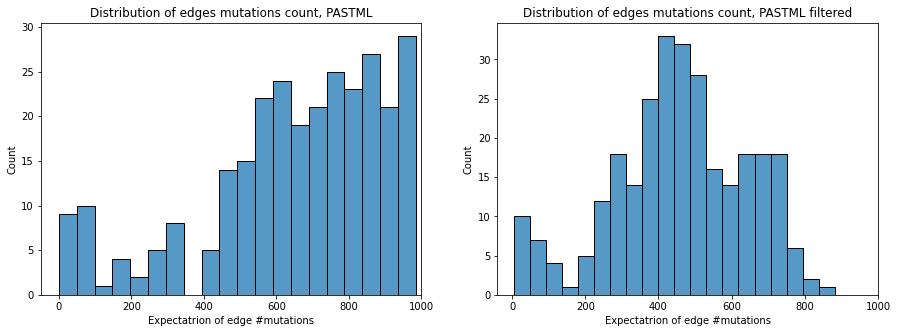

In [71]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(mut_pastml.groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, PASTML")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.subplot(122)
sns.histplot(mut_pastml[mut_pastml.ProbaFull > 0.1].groupby("AltNode").ProbaFull.sum(), bins=20)
plt.title("Distribution of edges mutations count, PASTML filtered")
plt.xlabel("Expectatrion of edge #mutations")
plt.xlim(None, 1000)
plt.show()

## Mutspec

In [72]:
# mutspec_simple = pd.read_csv("../data/processed/nematoda/30-05-22-16-39-29_rooted/mutspec192.tsv", sep='\t')
# mutspec_proba  = pd.read_csv("../data/processed/nematoda/proba/mutspec192.csv", sep='\t')
# mutspec_pastml = pd.read_csv("../data/processed/nematoda/pastml/mutspec192.csv", sep='\t')

mutspec_simple = pd.read_csv("../data/processed/nematoda/dif_approaches/simple/mutspec192.tsv", sep='\t')
mutspec_proba  = pd.read_csv("../data/processed/nematoda/dif_approaches/iqtree/mutspec192.tsv", sep='\t')
mutspec_pastml = pd.read_csv("../data/processed/nematoda/dif_approaches/pastml/mutspec192.tsv", sep='\t')

### Collapse to 96

In [73]:
translator = str.maketrans("ACGT", "TGCA")


def rev_comp(mut: str):
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut


def collapse_mutspec(ms192: pd.DataFrame):
    assert ms192.shape[0] == 192
    ms1 = ms192[ms192.Mut.str.get(2).isin(list("CT"))]
    ms2 = ms192[ms192.Mut.str.get(2).isin(list("AG"))]
    ms2["Mut"] = ms2["Mut"].apply(rev_comp)

    ms96 = pd.concat([ms1, ms2]).groupby("Mut")[["ObsFr", "ExpFr"]].sum()
    ms96["RawMutSpec"] = ms96["ObsFr"] / ms96["ExpFr"]
    ms96["MutSpec"] = ms96["RawMutSpec"] / ms96["RawMutSpec"].sum()
    ms96 = ms96.fillna(0)
    return ms96

In [74]:
mutspec_simple = mutspec_simple.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
mutspec_proba = mutspec_proba.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
mutspec_pastml = mutspec_pastml.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()

### Fulctions for plotting

TODO replace by AlexandrovLab functions

In [75]:
tmp_df = pd.DataFrame({"MutExt": mutspec_simple[mutspec_simple.Label == "ff"].Mut.unique()})
tmp_df["Mut"] = tmp_df.MutExt.str.get(2) + ">" + tmp_df.MutExt.str.get(4)
tmp_df["Context"] = tmp_df.MutExt.str.get(
    0) + tmp_df.MutExt.str.get(2) + tmp_df.MutExt.str.get(-1)
tmp_df.sort_values(["Mut", "Context"], inplace=True)
order96 = tmp_df.MutExt.values
order96.shape

(96,)

In [76]:
from itertools import groupby

import warnings
warnings.filterwarnings("ignore")

coloring = {
    "C>A": "lightblue",
    "C>G": "black",
    "C>T": "red",
    "T>A": "gray",
    "T>C": "green",
    "T>G": "pink",
}


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='black', linewidth=1)
    line.set_clip_on(False)
    ax.add_line(line)


def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]


def label_group_bar_table(ax, df):
    font = {
        'family': 'cursive',
        'color':  'black',
        'weight': 'normal',
        'size': 10,
    }
    rotation = 90
    ypos = -.04
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        if level == 0:
            rotation = 0
            font['size'] = 12

        pos = 0
        for label, rpos in label_len(df.index, level):
            lxpos = (pos + .5 * rpos) * scale
            ax.text(lxpos, ypos, label, ha='center', rotation=rotation,
                    fontdict=font, transform=ax.transAxes)
            if level == 0:
                add_line(ax, pos*scale, ypos)
            pos += rpos
        if level == 0:
            add_line(ax, pos*scale, ypos)
        ypos -= .05


def plot_mutspec192(edge_mutspec, label="Mutational spectra", filepath=None):
    edge_mutspec = edge_mutspec.copy()
    smpl = edge_mutspec.groupby("AltNode").get_group(edge_mutspec.AltNode.sample().item()).sort_values(["MutBase", "Context"])
    colors = smpl["MutBase"].map(coloring).values
    df = edge_mutspec.groupby(["MutBase", "Context"]).mean()
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    sns.barplot(
        x="Mut", y="MutSpec", data=edge_mutspec, 
        order=order96, errwidth=1, ax=fig.gca()
    )
    for bar, clr in zip(ax.patches, colors):
        bar.set_color(clr)
        bar.set_width(0.6)
    labels = ['' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    ax.set_xlabel('')
    ax.set_title(label)
    label_group_bar_table(ax, df)
    fig.subplots_adjust(bottom=.1*df.index.nlevels)
    if filepath is not None:
        plt.savefig(filepath)
    plt.show()

In [77]:
mutspec_simple["MutBase"] = mutspec_simple.Mut.str.slice(2, 5)
mutspec_simple["Context"] = mutspec_simple.Mut.str.get(0) + mutspec_simple.Mut.str.get(2) + mutspec_simple.Mut.str.get(-1)

mutspec_proba["MutBase"] = mutspec_proba.Mut.str.slice(2, 5)
mutspec_proba["Context"] = mutspec_proba.Mut.str.get(0) + mutspec_proba.Mut.str.get(2) + mutspec_proba.Mut.str.get(-1)

mutspec_pastml["MutBase"] = mutspec_pastml.Mut.str.slice(2, 5)
mutspec_pastml["Context"] = mutspec_pastml.Mut.str.get(0) + mutspec_pastml.Mut.str.get(2) + mutspec_pastml.Mut.str.get(-1)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


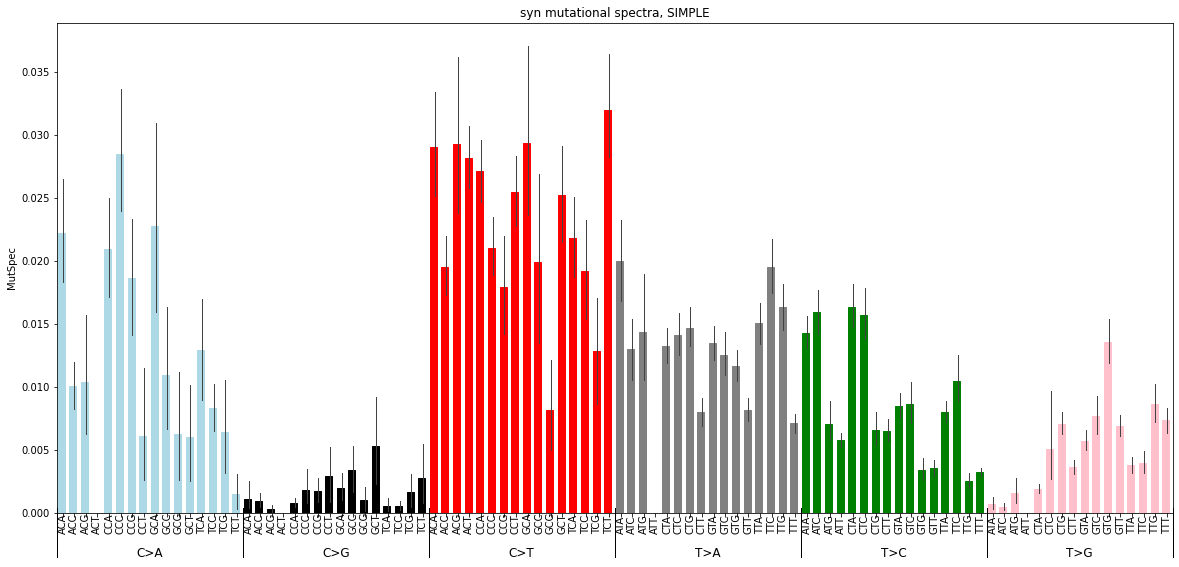

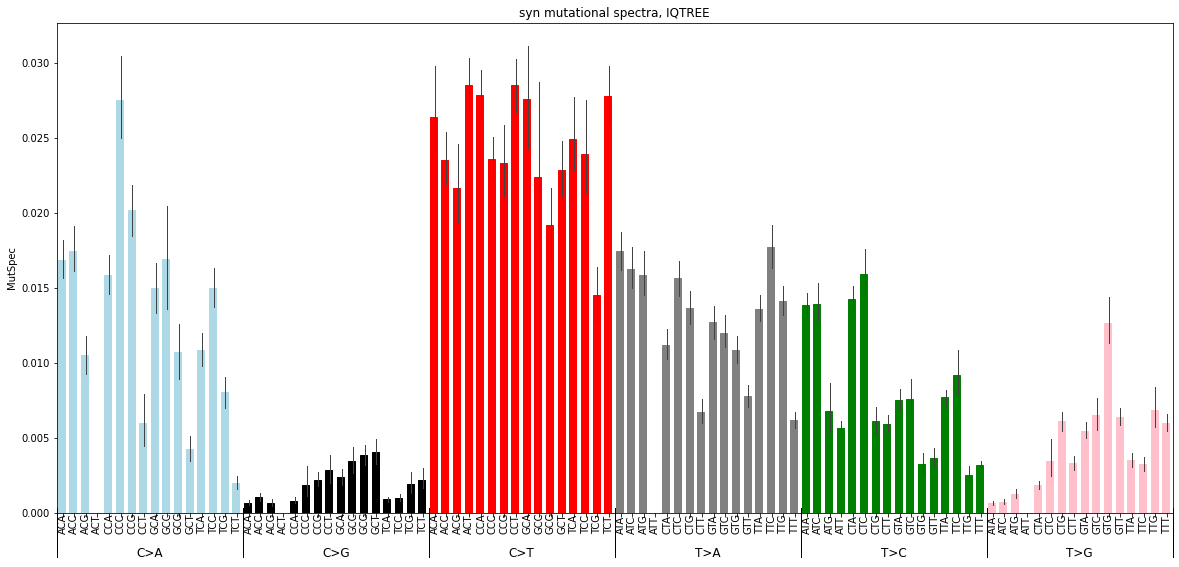

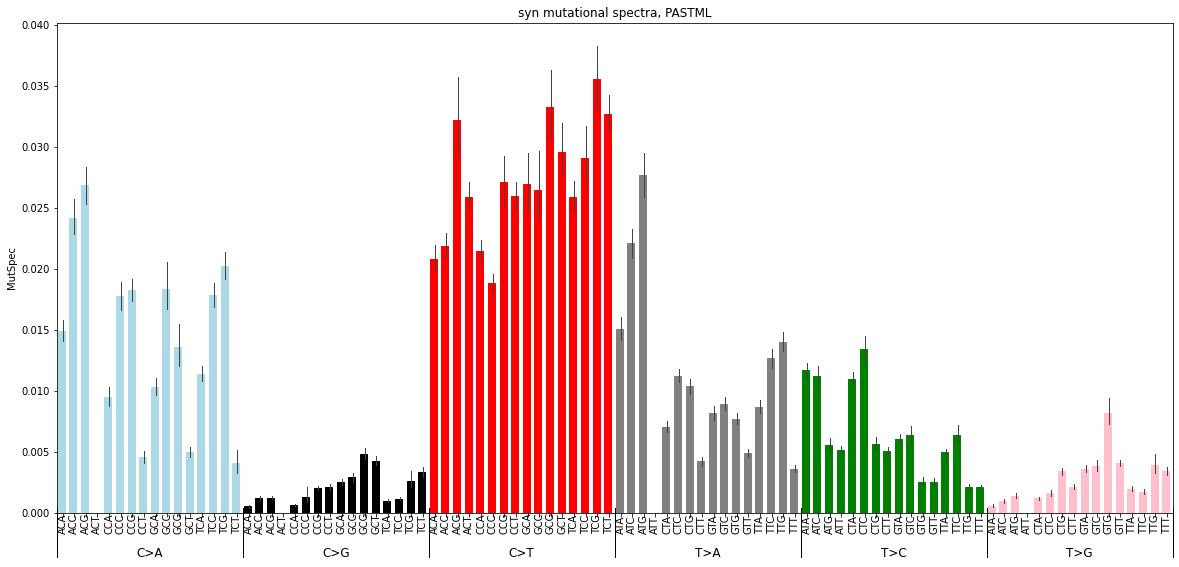

In [78]:
lbl = "syn"
plot_mutspec192(mutspec_simple[mutspec_simple.Label == lbl], f"{lbl} mutational spectra, SIMPLE")
plot_mutspec192(mutspec_proba[mutspec_proba.Label   == lbl], f"{lbl} mutational spectra, IQTREE")
plot_mutspec192(mutspec_pastml[mutspec_pastml.Label == lbl], f"{lbl} mutational spectra, PASTML")

In [134]:
sims_data = []
for lbl in mutspec_simple.Label.unique():
    for anode in set(mutspec_simple.AltNode):
        df1 = mutspec_simple[(mutspec_simple.Label == lbl) & (mutspec_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = mutspec_proba[(mutspec_proba.Label == lbl)   & (mutspec_proba.AltNode == anode) ].set_index("Mut").sort_index()
        df3 = mutspec_pastml[(mutspec_pastml.Label == lbl) & (mutspec_pastml.AltNode == anode)].set_index("Mut").sort_index()

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({
            "Label": "syn4f" if lbl == "ff" else lbl, 
            "AltNode": anode, 
            "cossim simple&iqtree": sim12, "cossim simple&pastml": sim13, "cossim iqtree&pastml": sim23,
        })
sims_df = pd.DataFrame(sims_data).sort_values("Label")

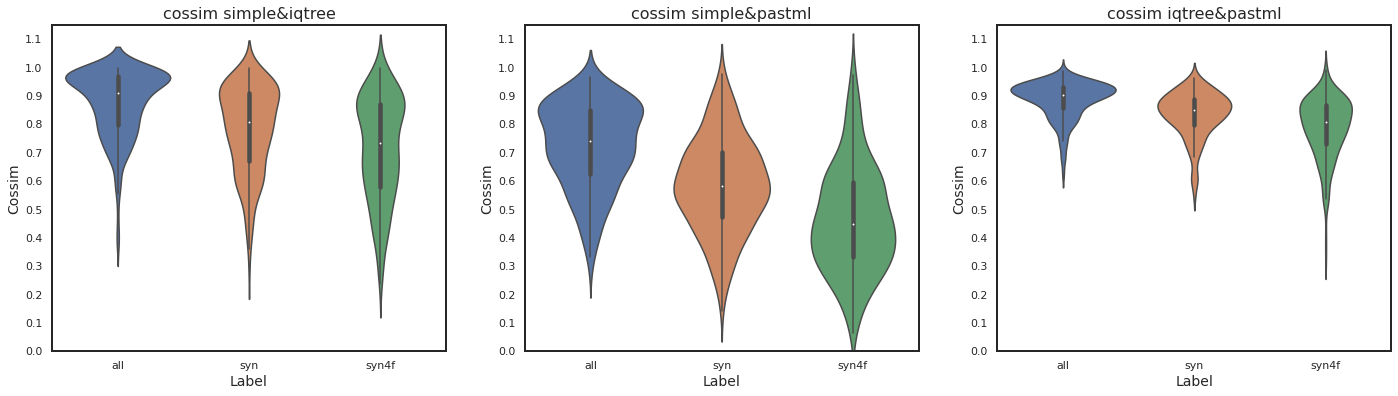

In [137]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(24, 6)
for i, cs_col in enumerate(sims_df.columns[-3:]):
    axs[i].set_xlabel(None, fontsize=14)
    axs[i].set_title(cs_col, fontsize=16)
    sns.violinplot(y=cs_col, x="Label", data=sims_df, ax=axs[i], fontdict={"fontsize": 16})
    axs[i].set_ylabel("Cossim", fontsize=14)
    axs[i].set_ylim(0, 1.15)
    axs[i].yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    axs[i].yaxis.set_major_formatter(ticker.ScalarFormatter())
    

## Categorizing mutations
We need to explore what mutations sample is responible for the bias

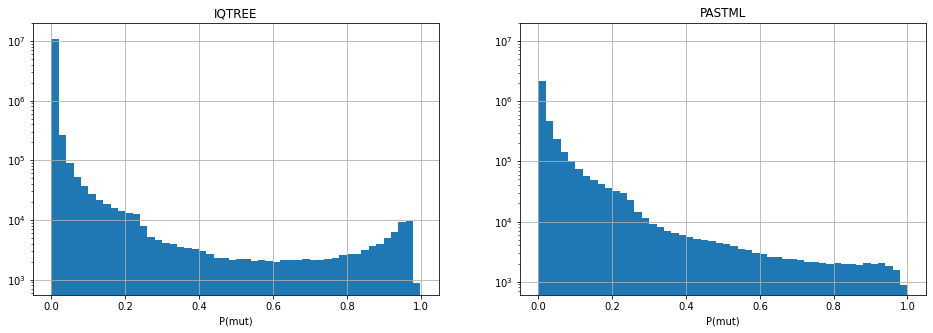

In [81]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
mut_iqtree.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("IQTREE")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)

plt.subplot(1,2,2)
mut_pastml.ProbaFull.hist(bins=50)
plt.yscale("log")
plt.title("PASTML")
plt.xlabel("P(mut)")
plt.ylim(0, 2e7)
plt.show()

Сколько мутаций в каждом интервале вероятностей у обоих подходов

In [82]:
print("p1\tp2\t#iqtree\t#pastml")
for x1 in np.linspace(0, 1, 21)[:-1]:
    x2 = x1 + 0.05
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > x1) & (mut_iqtree.ProbaFull <= x2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > x1) & (mut_pastml.ProbaFull <= x2)].ProbaFull.sum()
    print(f"{x1:.2f}\t{x2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

p1	p2	#iqtree	#pastml
0.00	0.05	31594.0	31738.3
0.05	0.10	8923.4	24386.0
0.10	0.15	7130.4	19384.6
0.15	0.20	6758.6	17346.9
0.20	0.25	6779.3	16573.9
0.25	0.30	3539.3	9695.3
0.30	0.35	3234.5	6744.7
0.35	0.40	3133.0	5947.6
0.40	0.45	2946.4	5570.4
0.45	0.50	2637.5	5458.3
0.50	0.55	2858.5	5175.0
0.55	0.60	2977.8	4648.9
0.60	0.65	3283.1	4233.7
0.65	0.70	3617.9	4010.3
0.70	0.75	3930.0	3996.0
0.75	0.80	4593.0	3932.7
0.80	0.85	5709.4	4057.6
0.85	0.90	8191.3	4342.5
0.90	0.95	14308.2	4603.3
0.95	1.00	14705.6	3203.3


Распределения сильно отличаются

### Load expected mutations freqs

In [84]:
path_to_freqs_simple = "../data/processed/nematoda/dif_approaches/simple/expected_mutations.tsv"
path_to_freqs_iqtree = "../data/processed/nematoda/dif_approaches/iqtree/expected_mutations.tsv"
path_to_freqs_pastml = "../data/processed/nematoda/dif_approaches/pastml/expected_mutations.tsv"

freqs_simple = pd.read_csv(path_to_freqs_simple, sep='\t').drop_duplicates()
freqs_iqtree = pd.read_csv(path_to_freqs_iqtree, sep='\t').drop_duplicates()
freqs_pastml = pd.read_csv(path_to_freqs_pastml, sep='\t').drop_duplicates()

In [85]:
freqs_simple.shape, freqs_iqtree.shape, freqs_pastml.shape

((5112, 207), (5112, 207), (5112, 207))

In [86]:
freqs_pastml.head()

,Node,Gene,Label,A>C,A>G,A>T,C>A,C>G,C>T,G>A,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,Node4,ATP6,all,70.625308,70.625308,70.625308,18.667411,18.667411,18.667411,55.608236,...,1.519538,4.973929,5.378621,2.378329,4.890554,16.159073,19.419708,3.875605,14.194646,62.031173
1,Node4,ATP6,syn,6.166732,19.988895,6.166732,0.663753,0.663753,2.443668,14.355871,...,0.950652,3.558064,1.895598,1.450709,2.185924,3.052364,1.036346,0.289068,1.252701,3.859288
2,Node4,ATP6,ff,6.166732,6.166732,6.166732,0.663753,0.663753,0.663753,4.184312,...,0.950652,3.558064,1.895598,1.450709,2.185924,3.052364,1.036346,0.289068,1.252701,3.859288
3,Node4,COX1,all,231.328643,231.328643,231.328643,106.951047,106.951047,106.951047,211.986854,...,14.690798,16.540555,20.450703,7.635107,15.253287,43.593269,52.758621,15.447792,45.120992,121.308089
4,Node4,COX1,syn,24.719724,69.406284,24.719724,3.792184,3.792184,13.096669,50.640989,...,12.565991,13.596501,11.400073,4.693569,7.680018,13.704796,5.338713,1.169621,3.332278,9.948570


In [185]:
def calc_tree_mutspec(mut, freqs, lbl="syn", pmin=0.0, pmax=1.0):
    """
    calculate tree mutspec from history files
    
    return 96comp mutspec of each edge in one table
    """
    # sample mutations
    mut = mut[(mut.ProbaFull > pmin) & (mut.ProbaFull <= pmax)]
    
    mutspec = []
    for (ref_node, alt_node), cur_mut in mut.groupby(["RefNode", "AltNode"]):
        # sample freqs
        _cur_freq_df = freqs[(freqs.Node == ref_node) & (freqs.Label == lbl)]
        cur_freq = _cur_freq_df[possible_sbs192].sum(axis=0).to_dict()

        # calculate mutspec
        ms192 = calculate_mutspec(cur_mut, cur_freq, lbl, use_context=True, use_proba=True)
        ms192["RefNode"] = ref_node
        ms192["AltNode"] = alt_node
        ms192["Label"] = lbl
        mutspec.append(ms192)
    mutspec_df = pd.concat(mutspec)
    mutspec_df = mutspec_df.groupby(["RefNode", "AltNode", "Label"]).apply(collapse_mutspec).reset_index()
    mutspec_df["MutBase"] = mutspec_df.Mut.str.slice(2, 5)
    mutspec_df["Context"] = mutspec_df.Mut.str.get(0) + mutspec_df.Mut.str.get(2) + mutspec_df.Mut.str.get(-1)
    return mutspec_df

In [165]:
space = [0.00, 0.05, 0.30, .50, 0.80, 1.00]

In [89]:
for p1, p2 in zip(space[:-1], space[1:]):
    mut_exp_num_iqtree = mut_iqtree[(mut_iqtree.ProbaFull > p1) & (mut_iqtree.ProbaFull <= p2)].ProbaFull.sum()
    mut_exp_num_pastml = mut_pastml[(mut_pastml.ProbaFull > p1) & (mut_pastml.ProbaFull <= p2)].ProbaFull.sum()
    print(f"{p1:.2f}\t{p2:.2f}\t{mut_exp_num_iqtree:.1f}\t{mut_exp_num_pastml:.1f}")

0.00	0.05	31594.0	31738.3
0.05	0.30	33130.9	87386.8
0.30	0.50	11951.4	23720.9
0.50	0.80	21260.4	25996.4
0.80	1.00	42914.5	16206.7


In [97]:
ms_cat_iqtree = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_iqtree, freqs_iqtree, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_iqtree.append(ms)

ms_cat_iqtree_df = pd.concat(ms_cat_iqtree)

In [98]:
ms_cat_pastml = []
for p1, p2 in zip(space[:-1], space[1:]):
    ms = calc_tree_mutspec(mut_pastml, freqs_pastml, "syn", p1, p2)
    ms["Cat"] = f"{p1:.2f}_{p2:.2f}"
    ms_cat_pastml.append(ms)

ms_cat_pastml_df = pd.concat(ms_cat_pastml)

### Categorized mutspec 

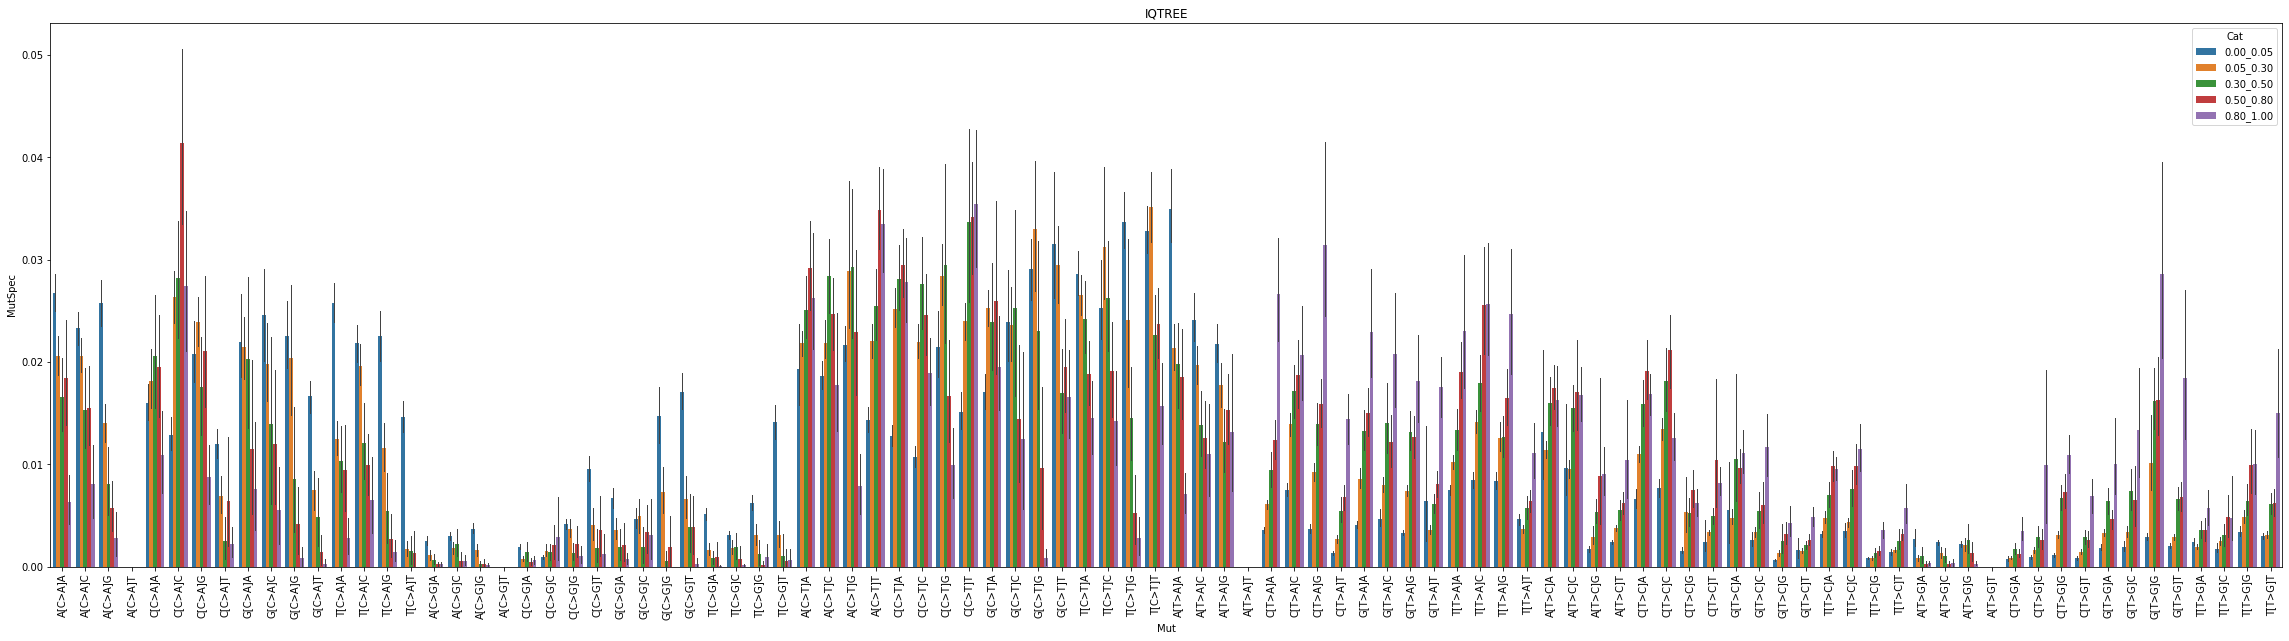

In [99]:
plt.figure(figsize=(40, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_iqtree_df, errwidth=1, order=order96
)
plt.title("IQTREE")
plt.xticks(rotation=90);

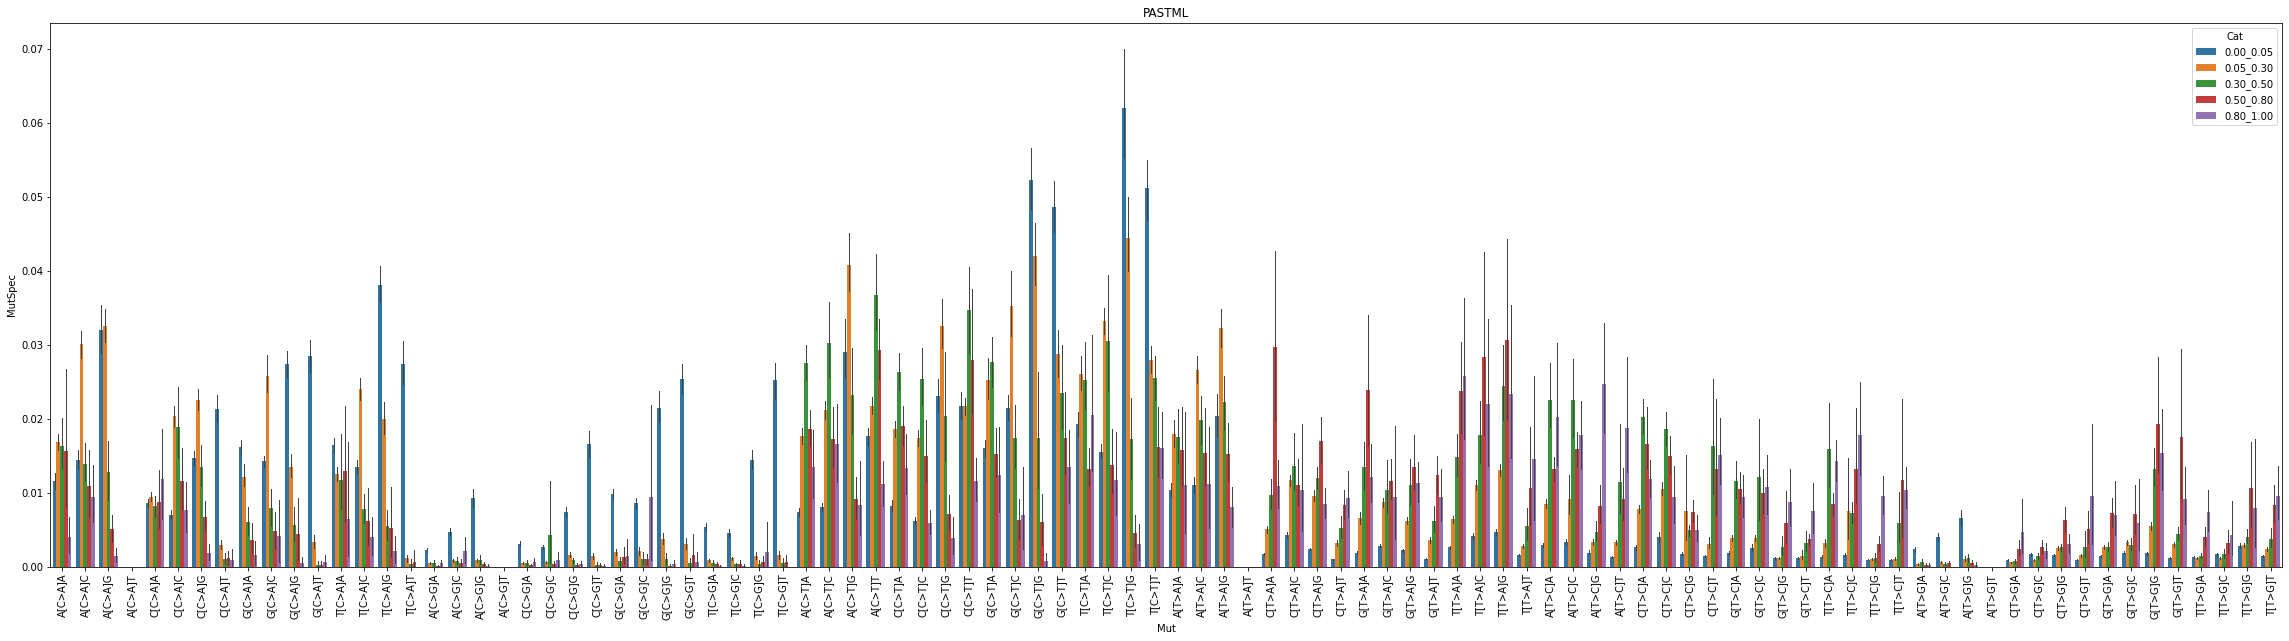

In [100]:
plt.figure(figsize=(40, 10))
sns.barplot(
    x="Mut", y="MutSpec", hue="Cat", data=ms_cat_pastml_df, errwidth=1, order=order96
)
plt.title("PASTML")
plt.xticks(rotation=90);

Разглядывать сложно. Но виден сильный дисбаланс.Как по низковероятным мутациям, так и по высоковероятным

### Compare cossim of mutspecs on mutations samples

In [173]:
def plot_compared(p1, p2, lbl="syn", constant_pastml=False):
    ms_simple = mutspec_simple[(mutspec_simple.Label == lbl)]
    ms_iqtree = calc_tree_mutspec(mut_iqtree, freqs_iqtree, lbl, p1, p2)
    if constant_pastml:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, 0, 1)
    else:
        ms_pastml = calc_tree_mutspec(mut_pastml, freqs_pastml, lbl, p1, p2)
    sims_data = []
    for anode in set(mutspec_simple.AltNode):
        df1 = ms_simple[(ms_simple.AltNode == anode)].set_index("Mut").sort_index()
        df2 = ms_iqtree[(ms_iqtree.AltNode == anode)].set_index("Mut").sort_index()
        df3 = ms_pastml[(ms_pastml.AltNode == anode)].set_index("Mut").sort_index()

        sim12 = 1 - spatial.distance.cosine(df1["MutSpec"], df2["MutSpec"])
        sim13 = 1 - spatial.distance.cosine(df1["MutSpec"], df3["MutSpec"])
        sim23 = 1 - spatial.distance.cosine(df2["MutSpec"], df3["MutSpec"])
        
        sims_data.append({"AltNode": anode, "Pair": "simple & iqtree", "Cossim": sim12})
        sims_data.append({"AltNode": anode, "Pair": "iqtree & pastml", "Cossim": sim23})
        sims_data.append({"AltNode": anode, "Pair": "simple & pastml", "Cossim": sim13})

    sims_df = pd.DataFrame(sims_data)
    
    # https://python.plainenglish.io/ridge-plots-with-pythons-seaborn-4de5725881af
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
    palette = sns.color_palette("Set2", 12)
    g = sns.FacetGrid(sims_df, palette=palette, row="Pair", hue="Pair", aspect=4, height=2.0)
    g.map_dataframe(sns.kdeplot, x="Cossim", fill=True, alpha=1)
    g.map_dataframe(sns.kdeplot, x="Cossim", color='black')

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, color='black', fontsize=13,
                ha="left", va="center", transform=ax.transAxes)
        
    g.map(label, "Pair")
    g.fig.subplots_adjust(hspace=-.5)
    g.set_titles("")
    g.set(yticks=[], xlabel="cossim", ylabel="")
    g.despine(left=True)
    title = f"Proba: ({p1}, {p2}]"
    if constant_pastml:
        title = f"Proba: iqtree: ({p1}, {p2}]; pastml: (0, 1]"
    plt.suptitle(title, y=0.98)
    plt.xlim(0, 1.01)
    plt.xticks(np.linspace(-0.1, 1.1, 13))
    plt.show()

Ниже графики, в которых мутспек считается по подвыборке мутаций с указанной вероятностью. 

Сначала идут графики, где мутации фильтровались как для iqtree, так и для pastml. Далее идут графики, где мутации фильтруются только у iqtree

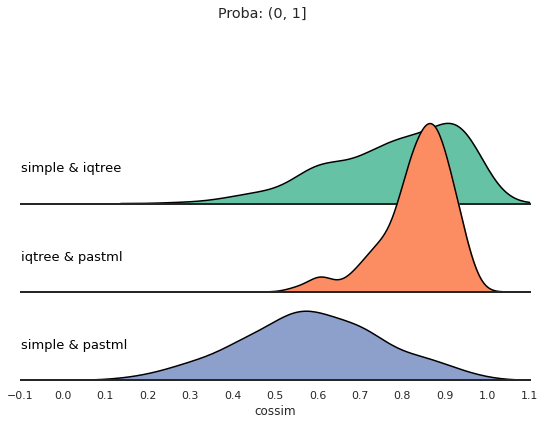

In [174]:
plot_compared(0, 1)

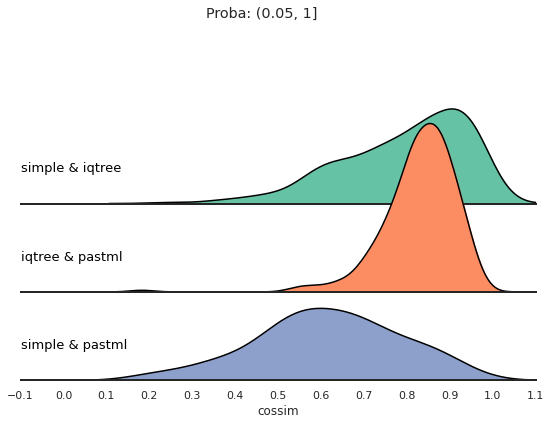

In [175]:
plot_compared(0.05, 1)

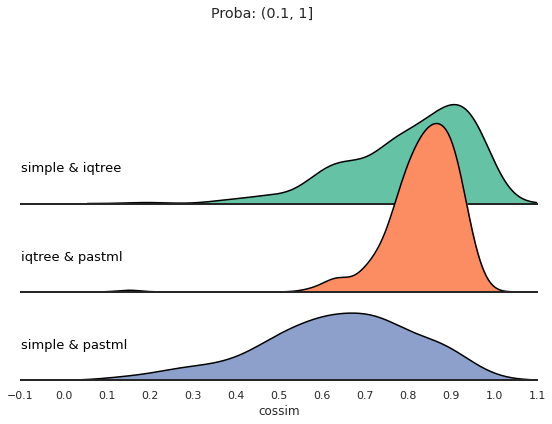

In [176]:
plot_compared(0.1, 1)

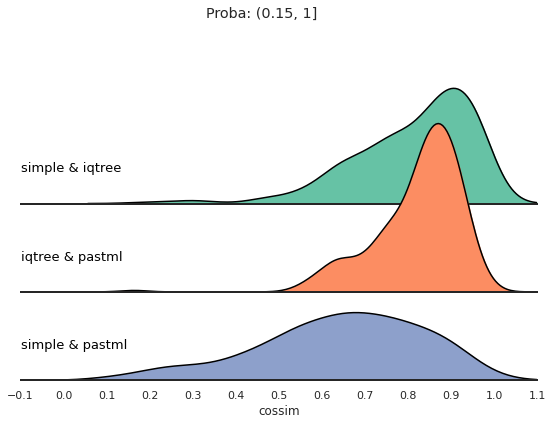

In [177]:
plot_compared(0.15, 1)

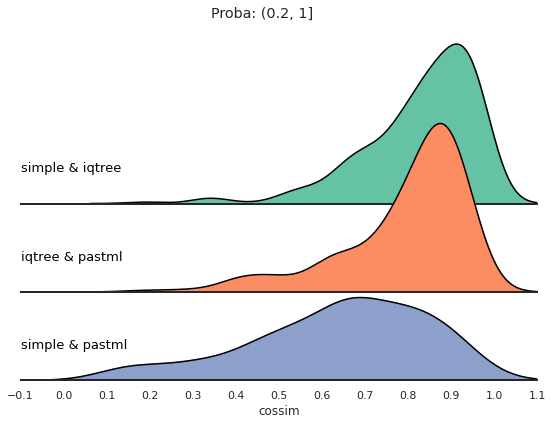

In [178]:
plot_compared(0.20, 1)

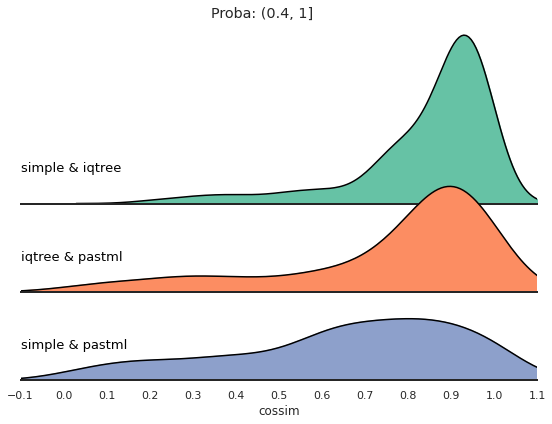

In [179]:
plot_compared(0.40, 1)

Далее полная выборка мутаций из pastml сравнивается с разными выборками из iqtree

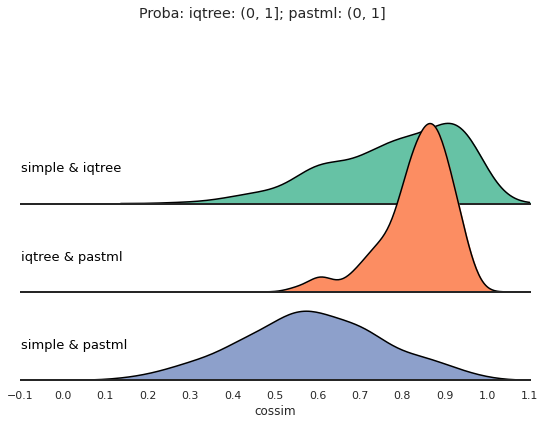

In [186]:
plot_compared(0, 1, constant_pastml=True)

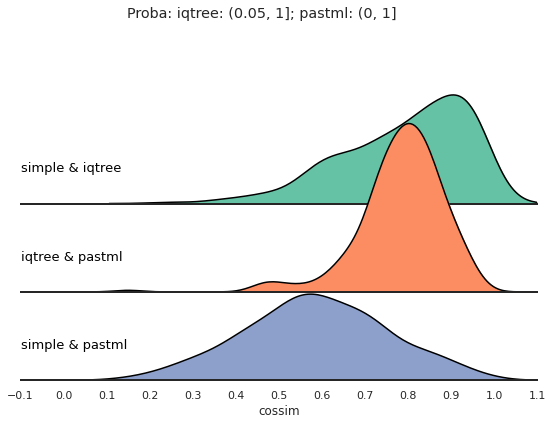

In [187]:
plot_compared(0.05, 1, constant_pastml=True)

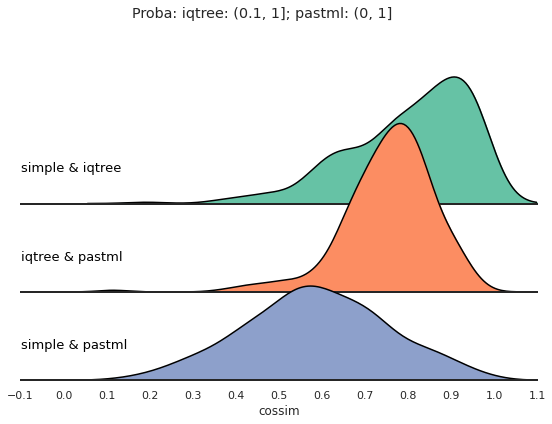

In [188]:
plot_compared(0.1, 1, constant_pastml=True)

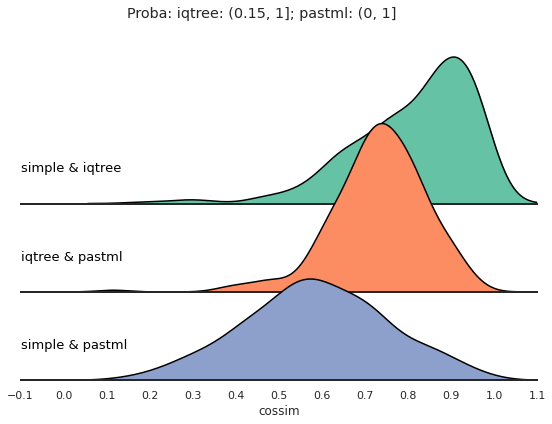

In [189]:
plot_compared(0.15, 1, constant_pastml=True)